In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
data = os.path.join('datasets', 'us_bonds_ph_rrr.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True).dropna()


df.head(-1)

,lt_bond,rrr
1986-01-01,9.19,12.00
1986-02-01,8.70,6.00
1986-03-01,7.78,15.00
1986-04-01,7.30,15.00
1986-05-01,7.71,5.00
...,...,...
2020-07-01,0.62,2.25
2020-08-01,0.65,2.25
2020-09-01,0.68,2.25
2020-10-01,0.79,2.25


C:\Users\Derrick\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


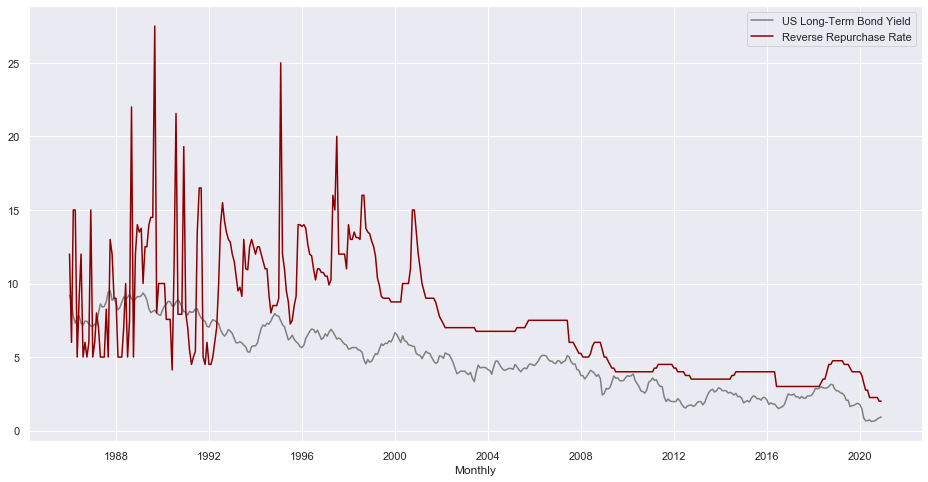

In [4]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(16,8))

plt.plot(df.lt_bond, color='tab:gray', label='US Long-Term Bond Yield')
plt.plot(df.rrr, color='darkred', label='Reverse Repurchase Rate')
#plt.title('')
plt.legend()
plt.xlabel('Monthly')

plt.show()

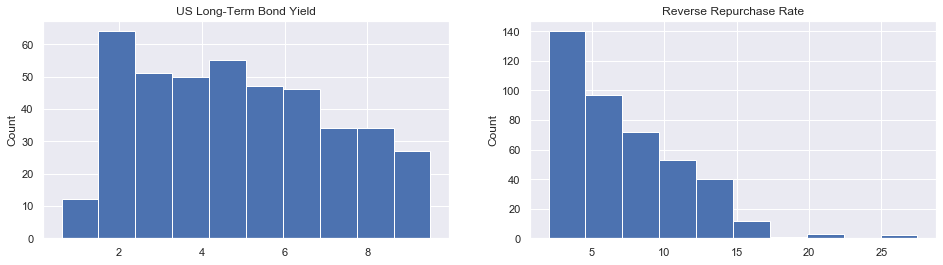

In [5]:
def normal_plots():
    fig = plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    plt.hist(df.lt_bond)
    plt.title('US Long-Term Bond Yield')
    plt.ylabel('Count')

    plt.subplot(1,2,2)
    plt.hist(df.rrr)
    plt.title('Reverse Repurchase Rate')
    plt.ylabel('Count')
    
    plt.show()

normal_plots()

In [6]:
#testing for stationarity
def adf_test(series, name=None, num=None):
    result = adfuller(series)
    if name == None:
        name = str(series.name)
    if num != None:
        name = 'Series %s' % str(num)
    print('\n%s:' %name)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

bonds = df.lt_bond
policy = df.rrr

adf_test(bonds)
print('Sample size: %s' %len(bonds))
adf_test(policy)
print('Sample size: %s' %len(policy))



lt_bond:
ADF Statistic: -0.877869
p-value: 0.795173
Sample size: 420

rrr:
ADF Statistic: -1.189715
p-value: 0.678005
Sample size: 420


In [7]:
# The following code consolidates transofrmation steps into one (and backtracks transformations)
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().fillna(method="bfill")
        d = variance_correct(d)
        #d = seasonality_correct(d).fillna(method="bfill")
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata

In [8]:
series = make_stationary(bonds, policy)

st_bonds = series[0]
st_policy = series[1].fillna(method='ffill')


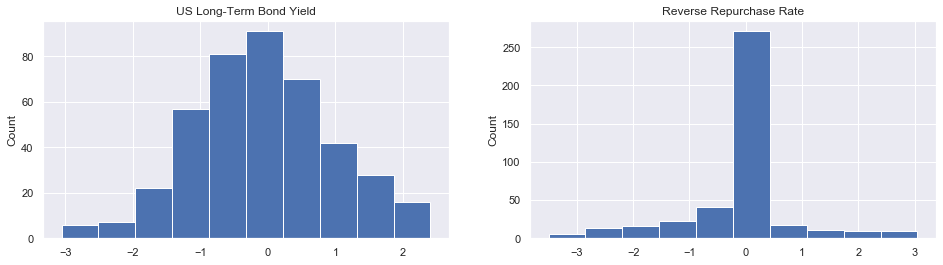

In [9]:
def normal_plots():
    fig = plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    plt.hist(st_bonds)
    plt.title('US Long-Term Bond Yield')
    plt.ylabel('Count')

    plt.subplot(1,2,2)
    plt.hist(st_policy)
    plt.title('Reverse Repurchase Rate')
    plt.ylabel('Count')
    
    plt.show()

normal_plots()


lt_bond:
ADF Statistic: -13.541642
p-value: 0.000000
Sample size: 420

rrr:
ADF Statistic: -6.940135
p-value: 0.000000
Sample size: 420


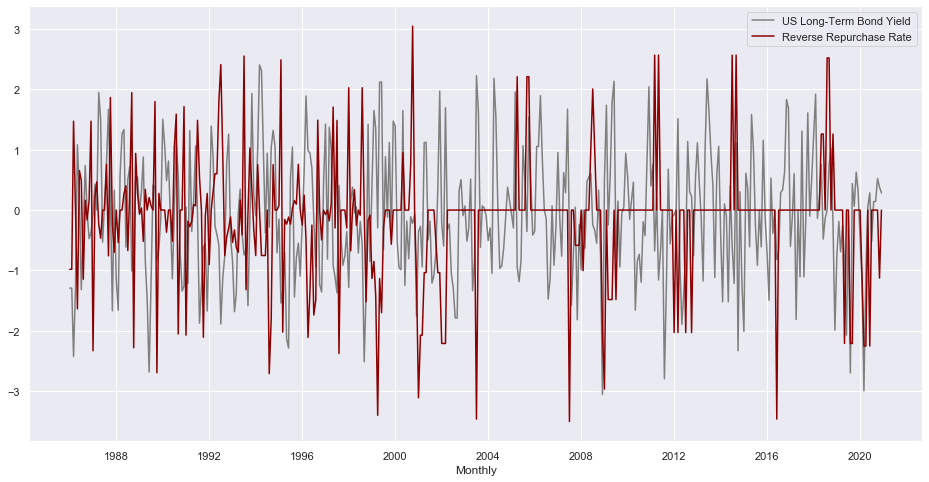

In [10]:
adf_test(st_bonds)
print('Sample size: %s' %len(st_bonds))
adf_test(st_policy)
print('Sample size: %s' %len(st_policy))

fig = plt.figure(figsize=(16,8))

plt.plot(st_bonds, color='tab:gray', label='US Long-Term Bond Yield')
plt.plot(st_policy, color='darkred', label='Reverse Repurchase Rate')
#plt.title('')
plt.legend()
plt.xlabel('Monthly')

plt.show()

### Testing Causality

In [11]:
def granger(s1, s2, lag=12):
    granger_df = pd.concat([s1, s2], axis=1).dropna()
    grangercausalitytests(granger_df, lag)

print('Testing causality\n')
granger(st_bonds,st_policy)


Testing causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3698  , p=0.0120  , df_denom=416, df_num=1
ssr based chi2 test:   chi2=6.4157  , p=0.0113  , df=1
likelihood ratio test: chi2=6.3671  , p=0.0116  , df=1
parameter F test:         F=6.3698  , p=0.0120  , df_denom=416, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4468  , p=0.0328  , df_denom=413, df_num=2
ssr based chi2 test:   chi2=6.9771  , p=0.0305  , df=2
likelihood ratio test: chi2=6.9195  , p=0.0314  , df=2
parameter F test:         F=3.4468  , p=0.0328  , df_denom=413, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8121  , p=0.0391  , df_denom=410, df_num=3
ssr based chi2 test:   chi2=8.5803  , p=0.0354  , df=3
likelihood ratio test: chi2=8.4932  , p=0.0368  , df=3
parameter F test:         F=2.8121  , p=0.0391  , df_denom=410, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2

***Correlation at lag = 0***

In [12]:
pearsonr(st_policy, st_bonds)

(-0.041321965620881675, 0.39828657941927026)

No handles with labels found to put in legend.


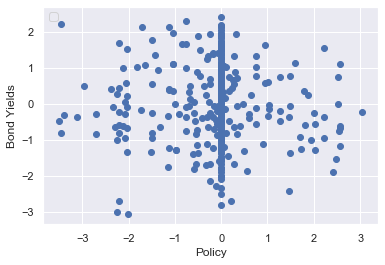

In [13]:
plt.scatter(st_policy, st_bonds)
plt.xlabel("Policy")
plt.ylabel("Bond Yields")
plt.legend(loc='upper left')
plt.show()

### Shows weak correlation

In [14]:
# Checking average difference of two time series
error = st_bonds - st_policy

np.mean(error)

0.034678547339472114

In [16]:
def create_df(*series):
    df = pd.concat(series, axis=1).dropna()
    n = []
    for i in series:
        n.append(i.name)
    df.columns = n
    return df

corr_df = create_df(st_policy, st_bonds)



### Fitting VAR Model

In [17]:
### AUTOMATE MODEL SELECTION
def fit_tsmodel(data, model='VAR', lags=4):
    models = ['VAR','SARIMAX']

    if model in models:
        if model == models[0]:
            model = VAR
        elif model == models[1]:
            model == SARIMAX
    else:
        print('Model not supported')
        return None
    
    fmodel = model(data)          
    res = fmodel.fit(maxlags=lags)
    return res

In [18]:
fdf = create_df(st_policy, st_bonds)
res = fit_tsmodel(fdf,lags=12)
res.summary()

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jan, 2021
Time:                     10:23:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.440493
Nobs:                     408.000    HQIC:                  0.143434
Log likelihood:          -1097.43    FPE:                   0.950491
AIC:                   -0.0510841    Det(Omega_mle):        0.843903
--------------------------------------------------------------------
Results for equation rrr
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.058184         0.049921           -1.166           0.244
L1.rrr              0.113962         0.050720            2.247           0.025
L1.lt_bond          0.096630         0.048145            2.007        

In [19]:
r2_score(res.fittedvalues['rrr']+res.resid['rrr'],
  res.fittedvalues['rrr'])

0.12039860852427064

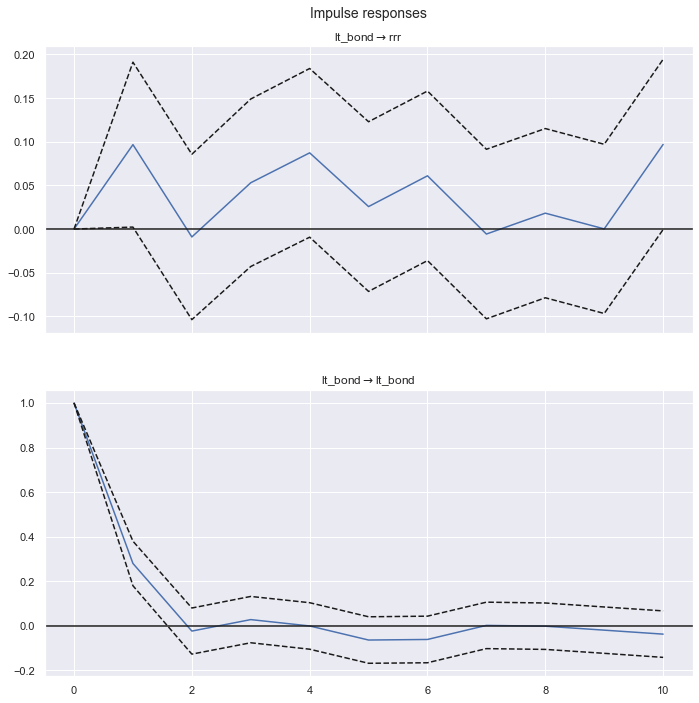

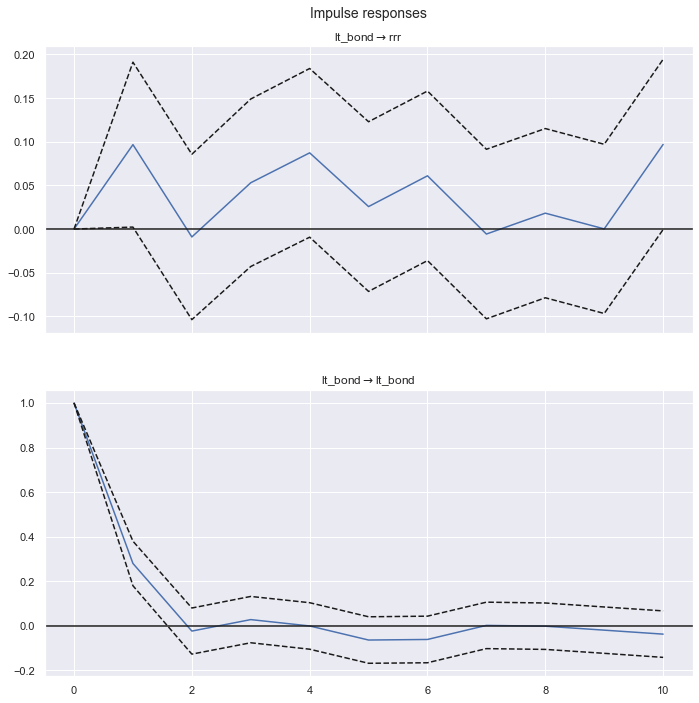

In [25]:
irf = res.irf(10)
irf.plot(orth=False, impulse='lt_bond')